# 005 - strain and stress analysis

Map stress and strain at pixel / grain scale using ImageD11.stress module, and make some plots. Also exports mapped properties to vtk format for paraview

What you need : 
- a pixelmap or a stack of pixelmap for which local indexing has been  performed. Grains must have been added if you want to compute grain strain and stress
- elastic constants cij for the phase(s) of interest.

### Load data 

In [2]:
import os, sys, glob, numpy as np, pylab as pl
from pathlib import Path
from tqdm import tqdm
from scipy.optimize import curve_fit

if '/home/esrf/jean1994b' not in sys.path:
    sys.path.append('/home/esrf/jean1994b')

import ImageD11.sinograms.dataset, ImageD11.columnfile, ImageD11.stress, ImageD11.grain
from orix import plot as opl, quaternion as oq, vector as ovec

from pf_3dxrd import utils, pixelmap, friedel_pairs, crystal_structure, grain_stress_fit
from mpl_toolkits.mplot3d import Axes3D
import scipy.ndimage as ndi

from uvw import RectilinearGrid, DataArray

%matplotlib ipympl
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
# paths
data_dir = 'data'
parfile='data/SI3.par'
sample = 'SI3'

dslist = ['SI3_DT360Z5480']   # list of datasets to load
pname = 'quartz'  # phase to analyze

# create new folder for outputs
outdir = os.path.join(data_dir, f'combined_{pname}')
!mkdir -p {outdir}


In [98]:
def load_data(dsname):
    xmappath = os.path.join(data_dir,dsname+'_xmap.h5')
    dspath   = os.path.join(data_dir,dsname+'_dataset.h5')
    
    xmap = pixelmap.load_from_hdf5(xmappath)
    xmap2 = xmap.filter_by_phase(pname)
    
    ds = ImageD11.sinograms.dataset.load(dspath)
    return xmap2, ds

In [99]:
%%time
# load data from all xmaps and store them in a big dict

# define dict to store data, labels, etc.
keys = ['dsname', 'ds', 'xmap']
vals = [[] for _ in range(len(keys))]        
xmap_dict = dict(zip(keys,vals))        
    
# load xmaps
for ds in dslist:
    xmap, ds = load_data(ds)
    xmap_dict['ds'].append(ds)
    xmap_dict['dsname'].append(ds.dsname)
    xmap_dict['xmap'].append(xmap)

xmap_dict['dsname']

CPU times: user 637 ms, sys: 1.29 s, total: 1.93 s
Wall time: 448 ms


['SI3_DT360Z5480']

### Define reference unit cell and add elastic constants

#### Get reference unit cell
Strain is computed relative to a reference. This can be the reference unit cell provided in the cif file ("absolute" strain), or the mean or median of your data or a subset of it, or whatever else you want as long as it makes sense.

In [100]:
# Take reference cell from the cif file: stored in xmap.phases
xmap = xmap_dict['xmap'][0]
B0 = xmap.phases.get(pname).cell
B0

array([  4.91325,   4.91325,   5.41206,  90.     ,  90.     , 120.     ])

In [84]:
# Compute Median unit cell over the map
xmap = xmap_dict['xmap'][0]
B0 = np.median(xmap.unitcell[xmap.unitcell[:,0] > 0], axis=0)
B0 

array([  4.9179209 ,   4.91874486,   5.41123521,  90.01258804,
        89.9920822 , 119.98763547])

#### Add elastic constants
Elastic constants are added to crystal_structure (CS) objects in CS.elastic_pars.

In [101]:
# quartz elastic constants (from Heyliger et al., 2003)
c11 = 87.16  * 1e3
c12 = 6.64   * 1e3
c13 = 12.09  * 1e3
c14 = -18.15 * 1e3
c33 = 106.00 * 1e3
c44 = 58.14  * 1e3
c66 = 40.26  * 1e3

for xmap in xmap_dict['xmap']:
    xmap.phases.quartz.add_elastic_constants(symmetry='trigonal_low',
                                             c11=c11,
                                             c12=c12,
                                             c13=c13,
                                             c14=c14,
                                             c33=c33,
                                             c44=c44,
                                             c66=c66)
    
xmap.phases.quartz.elastic_pars.as_dict()

{'c11': 87160.0,
 'c12': 6640.0,
 'c13': 12090.0,
 'c14': -18150.0,
 'c33': 106000.0,
 'c44': 58140.0,
 'c66': 40260.0}

In [87]:
# orthoclase elastic constants (Waeselmann et al. 2016, Or93)
# "orthorombic" modulii
c11 = 67.8  * 1e3
c22 = 181.2  * 1e3
c33 = 158.4  * 1e3
c44 = 20.1  * 1e3
c55 = 19.4  * 1e3
c66 = 33.1  * 1e3
c12 = 40.4  * 1e3
c13 = 25.0  * 1e3
c23 = 20.6  * 1e3

# other off-diagonal modulii
c15 = -1.1  * 1e3
c25 = -12.9  * 1e3
c35 = 10.6  * 1e3
c46 = -11.6  * 1e3

for xmap in xmap_dict['xmap']:
    xmap.phases.orthoclase.add_elastic_constants(symmetry='trigonal_low',
                                             c11=c11, c12=c12, c13=c13, c14=None, c15=c15, c16=None,
                                             c22=c22, c23=c23, c24=None, c25=c25, c26=None,
                                             c33=c33, c34=None, c35=c35, c36=None,
                                             c44=c44, c45=None, c46=c46,
                                             c55=c55, c56=None,
                                             c66=c66)


AttributeError: 'PHASES' object has no attribute 'orthoclase'

### Compute strain and stress

Strain and stress computations are done using the stress solver in ImageD11.stress. Doing all the strain/stress calculaion for pixels / grains in xmap, extracting the results and updating xmaps can be a bit tedious. The module pf_3dxrd.grain_stress_fit allows to handle this in a more handy way. 

In [102]:
# Arguments passed to grain_stess_fit.solve_strain_stress function, controls what is computed

kwargs = {'m_exponent'       : 1,               # exponent for the Seth-Hill finite strain tensors E = 1/2m (U^2m - I)
          'reference_frame'  : 'Lab',           # reference frame in which strain and stress are computed. 'Lab' or 'Grain'
          'output_format'    : 'voigt',         # output format for strain / stress. One of 'tensor','voigt','mandel','xfab','default'
          'deviatoric'       : True,            # compute deviatoric strain / stress
          'invariants'       : True,            # compute invariant properties: -I1/3 (Pressure), (√3.J2) (von Mises stress)
          'principal_components' : True,        # compute principal components (sigma1, sigma2, sigma3)
          'deviatoric_pc'        : False}       # if True, principal components are computed for the deviatoric tensors. Default=False


# compute strain and stress and add results to xmap
for xmap in xmap_dict['xmap']:
    # strain / stress for pixels
    grain_stress_fit.xmap_strain_stress_px(xmap, pname, B0 = B0, stress_unit='MPa', overwrite_xmap=True, **kwargs)
    
    # strain / stress for grains
    grain_stress_fit.xmap_strain_stress_grains(xmap, pname,  B0 = B0, stress_unit='MPa', overwrite_xmap=True, **kwargs)

computing deformation gradient tensor...
computing strain and stress...
computing additional properties...
deviatoric tensors...
strain/stress invariants...
principal strain/stress components...
converting tensors to vecs...
computing deformation gradient tensor...
computing strain and stress...
computing additional properties...
deviatoric tensors...
strain/stress invariants...
principal strain/stress components...
converting tensors to vecs...


37it [00:00, 143960.34it/s]
37it [00:00, 14240.16it/s]
37it [00:00, 477505.38it/s]
37it [00:00, 46814.25it/s]
37it [00:00, 649327.40it/s]
37it [00:00, 43120.10it/s]
37it [00:00, 764479.05it/s]
37it [00:00, 55385.17it/s]
37it [00:00, 564324.54it/s]
37it [00:00, 40850.03it/s]
37it [00:00, 608585.29it/s]
37it [00:00, 48436.09it/s]
37it [00:00, 620756.99it/s]
37it [00:00, 48740.34it/s]
37it [00:00, 592325.37it/s]
37it [00:00, 36592.61it/s]
37it [00:00, 554247.31it/s]
37it [00:00, 35990.09it/s]
37it [00:00, 546441.01it/s]
37it [00:00, 41739.98it/s]
37it [00:00, 570548.71it/s]
37it [00:00, 45778.54it/s]
37it [00:00, 572654.05it/s]
37it [00:00, 38904.30it/s]


### Save xmap and export to vtk

Export outputs to paraview. If a stack of xmaps is provided, data arrays will be concatenated to a 3D volume.

In [49]:
# save pixelmaps with full strain and stress columns
for xmap in xmap_dict['xmap']:
    xmap.save_to_hdf5(save_mode='full')  

Pixelmap saved to: data/SI3_DT360Z5480_xmap_quartz.h5


In [51]:
def stack_2D_slices(xmap_list, dname):
    """ stack data from 2D z-slices stored in dictionnary and return them as a 3D volume. Required if working with 3D dataset"""
    
    assert all([dname in x.titles() for x in xmap_list]), 'data array is missing in at least one xmap'
    
    # data shape
    x0 = xmap_list[0]
    nx, ny = x0.grid.nx, x0.grid.ny
    array_shape = x0.get(dname).shape
    
    # stack ndarrays
    if len(array_shape) == 1:
        stacked_ndarray = np.array([x.get(dname).reshape(nx,ny) for x in xmap_list])
    else:
        newshape = (nx,ny,) + array_shape[1:]
        stacked_ndarray = np.array([x.get(dname).reshape(newshape) for x in xmap_list])
        
    # swap axes to get z-axis in last coordinates
    stacked_ndarray = np.swapaxes(stacked_ndarray, 0,2)
    print(f'stacked array {dname} : {stacked_ndarray.shape}')
    
    return stacked_ndarray


def xmap_stack_to_vtk(xmap_stack, coords_z_stack = None, to_skip=None, skip_bulk_grain_props = True, outname=None):
    """
    export xmap stack to vtk format for paraview.
    
    Args:
    -------
    xmap_stack    : stack of xmaps (list)
    coord_z_stack : z coordinate of each slice in the stack (np.array)
    to_skip       : list of properties to skip (list of strings)
    skip_bulk_grain_prop : skip bulk grain properties (default=True)
    outname       : output name. Default is datasetname_xmap_phasename.vtr
    """
    
    # Grid coordinates
    # x,y
    xmap = xmap_stack[0]
    x, y = xmap.grid.xbins, xmap.grid.ybins
    
    # z
    if coords_z_stack is None:
        px = xmap.grid.pixel_size
        z = np.arange(0,len(xmap_stack)*px,px)
    else:
        assert len(coords_z_stack) == len(xmap_stack)
        z = coords_z_stack
        
    # define properties to skip (not saved): grid index and U/UBI are not saved by default
    to_skip_default = 'xyi,xi,yi,U,UBI'.split(',')
    if to_skip is None:
        to_skip = to_skip_default
    else:
        to_skip.extend(to_skip_default)
        
    # export pixelmap properties to 3D grid
    # file name for output
    if outname is None:
        outname = xmap.h5name.replace('h5','vtr')
        
    # open Rectilinear grid object
    with RectilinearGrid(outname, (x, y, z), compression=True) as grid3D:
        
        # loop through xmap properties and export to vtk
        for dname in xmap.titles():
            if dname in to_skip:
                continue
            if all(['_g' in dname, skip_bulk_grain_props]):  # skip bulk grain properties if this option is set to True
                continue
        
            data = stack_2D_slices(xmap_stack, dname)    
            grid3D.addPointData(DataArray(data, range(3), dname))
    
        grid3D.write()
        
    print('Export to vtk completed')

In [52]:
# export to vtk file for paraview. You can decide to skip some columns if you want
# Note: Principal components can be computed in paraview, so it is useless to export them 

to_skip = [t for t in xmap.titles() if 'eigval' in t or 'eigvec' in t]
print('to skip', to_skip)


xmap_stack_to_vtk(xmap_dict['xmap'], skip_bulk_grain_props=False, to_skip=to_skip)

to skip ['strain_Lab_eigvals', 'strain_Lab_eigvecs', 'stress_Lab_eigvals', 'stress_Lab_eigvecs', 'strain_Lab_eigvals_g', 'strain_Lab_eigvecs_g', 'stress_Lab_eigvals_g', 'stress_Lab_eigvecs_g']
stacked array phase_id : (110, 110, 1)
stacked array grain_id : (110, 110, 1)
stacked array Npks : (110, 110, 1)
stacked array completeness : (110, 110, 1)
stacked array drlv2 : (110, 110, 1)
stacked array nindx : (110, 110, 1)
stacked array phase_label_confidence : (110, 110, 1)
stacked array uniqueness : (110, 110, 1)
stacked array unitcell : (110, 110, 1, 6)
stacked array strain_Lab_d_voigt : (110, 110, 1, 6)
stacked array strain_Lab_vM : (110, 110, 1)
stacked array strain_Lab_voigt : (110, 110, 1, 6)
stacked array strain_Lab_vol : (110, 110, 1)
stacked array stress_Lab_P_hyd : (110, 110, 1)
stacked array stress_Lab_d_voigt : (110, 110, 1, 6)
stacked array stress_Lab_vM : (110, 110, 1)
stacked array stress_Lab_voigt : (110, 110, 1, 6)
stacked array strain_Lab_d_voigt_g : (110, 110, 1, 6)
stack

### Make some plots
Now you can play with the vtr file in paraview. You can also use the functions below to plot serial slices of the 3D volume in one figure.

In [53]:
os.path.exists( os.path.dirname(xmap.h5name))
outpath = Path(*Path(xmap.h5name).parts[:-2])/ f'combined_{pname}'


In [103]:
def plot_maps_combined(xmap_stack,
                       titles,
                       property_name,
                       dim=0,
                       smooth=False,
                       mfs=3,
                       n_columns = 2,
                       save=False,
                       outdir = None,
                       **kw):
    """ plot on the same figure 2D maps of the selected property for all xmaps in xmap_stack """
    
    if save:
        if outdir is None:
            outpath = Path(*Path(xmap.h5name).parts[:-2])/ f'combined_{pname}'
            outdir = str(outpath)
        else:
            outpath = Path(outdir)
        !mkdir -p {outdir}
    
    prop = property_name  # alias
    
    # define fig size and axes + create new figure
    nrows = np.ceil(len(xmap_stack) / n_columns).astype(int)
    
    fig, ax = pl.subplots(nrows,n_columns,figsize=(3*n_columns, 3*nrows), sharex=True, sharey=True, constrained_layout=True)
    
    ax = ax.ravel()
    for a in ax:
        a.set_axis_off()
    
    if titles is None:
        titles = [os.path.basename(x.h5name)[:-3] for x in xmap_stack]
    
    for x,a,t in zip(xmap_stack, ax, titles):
        # bins and shape for pcolormesh
        nx,ny = x.grid.nx, x.grid.ny
        xb, yb = x.grid.xbins, x.grid.ybins
        
        a.set_aspect('equal')
        a.set_title(t, fontsize=9)
        a.add_artist(x.grid.scalebar())
        
        # get xmap property and reshape them
        dat = x.get(prop).copy().astype(float)
        if len(dat.shape) == 1:
            dat[x.phase_id == -1] = -np.inf  # replace values of "notindexed" pixels by -np.inf
            dat = dat.reshape(nx,ny)
            suptitle = f'{prop}'
            if save:
                fname = str(outpath) + f'/{prop}.png'
        else:
            dat[:,dim][x.phase_id == -1] = -np.inf
            dat = dat[:,dim].reshape(nx,ny)
            suptitle = f'{prop} | dim={dim}'
            if save:
                fname = str(outpath) + '/'+'_'.join([prop,str(dim)+'.png'])
        
        # median value for colormap scaling
        s = np.all([dat != np.inf, dat != -np.inf, dat != 0, dat != -1], axis=0)
        med = np.median(dat[s])
        
        # apply median filter if smooth is True
        if smooth:
            dat = ndi.median_filter(dat, size=mfs)
        
        # plot
        im = a.pcolormesh(xb, yb, dat, **kw)

    # colorbar on the bottom
    cbar=fig.colorbar(im, ax = ax[-n_columns:], location='bottom',shrink=0.5, label=prop)   
    if not 'vM' in prop:
        cbar.formatter.set_powerlimits((-3, 3)) 
    
    fig.suptitle(suptitle)
    
    if save:
        fig.savefig(fname, format='png', dpi=200) 

    return fig



def plot_polefigs_combined(xmap_stack,
                           titles,
                           property_name,
                           dim=0,
                           n_columns = 2,
                           polar_res=0.5,
                           az_res=0.5,
                           save=False,
                           outdir = None,
                           **kw):
    """ plot polefigures (for 3D orientation in SO(3)) for all xmaps in xmap_stack """
    
    if save:
        if outdir is None:
            outpath = Path(*Path(xmap.h5name).parts[:-2])/ 'combined'
            outdir = str(outpath)
        else:
            outpath = Path(outdir)
        !mkdir -p {outdir}
    
    prop = property_name  # alias
    
    # define fig size and axes + create new figure
    nrows = np.ceil(len(xmap_stack) / n_columns).astype(int)
    
    fig, ax = pl.subplots(nrows,n_columns,figsize=(3*n_columns, 3*nrows), sharex=True, sharey=True, layout='constrained',
                         subplot_kw={'projection':'stereographic',
                                      'hemisphere':'lower',
                                      'polar_resolution':polar_res,
                                      'azimuth_resolution':az_res})
    ax = ax.ravel()
    for a in ax:
        a.set_axis_off()
    
    if titles is None:
        titles = [os.path.basename(x.h5name)[:-3] for x in xmap_stack]
    
    for x,a,t in zip(xmap_stack, ax, titles):
        a.set_title(t, fontsize=8)

        #look at principal strain orientation
        v = x.get(prop)[:,:,dim]
        # reproject vectors pointing upward on lower hemisphere
        v = -1 * np.multiply(np.sign(v[:,-1])[:, np.newaxis], v)
        # filter out bad data
        ok = np.all([[np.sum(vec) != 0 for vec in v], x.drlv2 < 1.5e-2, x.phase_id !=-1],axis=0)
        # export as orix Vector3d object
        V = ovec.Vector3d(v[ok])
    
        a.pole_density_function(V, **kw)
        a.set_labels("x","y",None)
    
    fig.suptitle('pole density function '+prop+' – dim='+str(dim))
    if save:
        fname = str(outpath) + '/'+'_'.join([prop,str(dim),'polefigs.png'])
        fig.savefig(fname, format='png', dpi=200)
    return fig
        
        
        
def plot_ang_maps_combined(xmap_stack,
                       titles,
                       property_name,
                       dim=0,
                       v0 = ovec.Vector3d.zvector(),
                       smooth=False,
                       mfs=3,
                       n_columns = 2,
                       save=False,
                       outdir = None,
                       **kw):
    """ plot on the same figure 2D maps of the selected property for all xmaps in xmap_stack """
    
    if save:
        if outdir is None:
            outpath = Path(*Path(xmap.h5name).parts[:-2])/ 'combined'
            outdir = str(outpath)
        else:
            outpath = Path(outdir)
        !mkdir -p {outdir}
    
    prop = property_name  # alias
    
    # define fig size and axes + create new figure
    nrows = np.ceil(len(xmap_stack) / n_columns).astype(int)
    
    fig, ax = pl.subplots(nrows,n_columns,figsize=(3*n_columns, 3*nrows), sharex=True, sharey=True, layout='constrained')
    
    ax = ax.ravel()
    for a in ax:
        a.set_axis_off()
    
    if titles is None:
        titles = [os.path.basename(x.h5name)[:-3] for x in xmap_stack]
    
    for x,a,t in zip(xmap_stack, ax, titles):
        # bins and shape for pcolormesh
        nx,ny = x.grid.nx, x.grid.ny
        xb, yb = x.grid.xbins, x.grid.ybins
        
        a.set_aspect('equal')
        a.set_title(t, fontsize=9)
        a.add_artist(x.grid.scalebar())
        
        # xmap grid
        nx,ny = x.grid.nx, x.grid.ny
        xb, yb = x.grid.xbins, x.grid.ybins
        
        v = x.get(prop)[:,:,dim]
        v = -1 * np.multiply(np.sign(v[:,-1])[:, np.newaxis], v)
        ok = np.all([[np.sum(vec) != 0 for vec in v], x.drlv2 < 1.5e-2, x.drlv2>0,  x.phase_id !=-1],axis=0)
        V = ovec.Vector3d(v[ok])
    
        # angle between vec and v0 (degree)
        ang = V.angle_with(v0, degrees=True)
        ang = 90 - np.abs(ang-90)  # rescale angle to [0,90°] 
        # map l_ang to xmap
        #ang_map = np.zeros_like(x.drlv2)
        ang_map = np.full(x.xyi.shape, np.inf)
        
        ang_map[ok] = ang
        if smooth:
            ang_map = ndi.median_filter(ang_map.reshape(nx,ny), size=mfs)
        else:
            ang_map = ang_map.reshape(nx,ny)
            
        im=a.pcolormesh(xb, yb, ang_map, **kw)
        
        
    # colorbar on the bottom
    cbar=fig.colorbar(im, ax = ax[-n_columns:], location='bottom',shrink=0.5, label=prop)   
    if not 'vM' in prop:
        cbar.formatter.set_powerlimits((-3, 3)) 
    fig.suptitle(f'principal stress orientation dim={dim}')
    
    if save:
        fname = str(outpath) + '/'+'_'.join([prop,str(dim),'angmap.png'])
        fig.savefig(fname, format='png', dpi=200) 

    return fig


In [89]:
def custom_cmap(mapname, color_under=None, color_over=None):
    cmap =  pl.matplotlib.colormaps.get(mapname).copy()
    cmap.set_extremes(under=color_under, over=color_over)
    return cmap

In [65]:
# map grain orientation to compute misorientation
for xmap in xmap_dict['xmap']:
    xmap.map_grain_prop('U', pname)

37it [00:00, 1166.28it/s]


#### Combined plot with same property for all slices

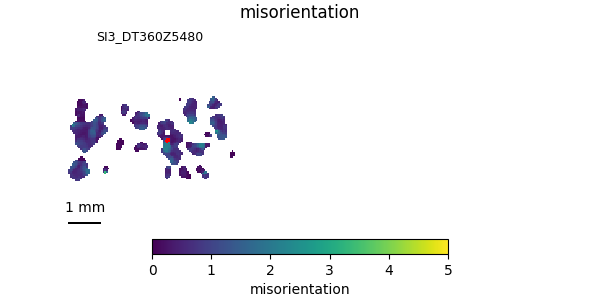

In [66]:
pl.close('all')
save=False
dname = 'misorientation'
dim=0

kw = {'cmap':custom_cmap('viridis', color_under='w', color_over='r'), 'vmin':0, 'vmax':5}

fig = plot_maps_combined(xmap_dict['xmap'], xmap_dict['dsname'], dname, dim, smooth=True, mfs=3, n_columns=2,
                         save=save, outdir = outdir, **kw)

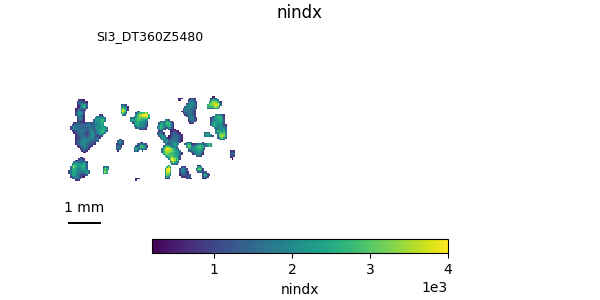

In [68]:
# regular scalar property: drlv2, nindx, etc.

pl.close('all')
save=True
dname = 'nindx'

kw = {'cmap':custom_cmap('viridis', color_under='w'), 'vmin':200, 'vmax':4000}

fig = plot_maps_combined(xmap_dict['xmap'], xmap_dict['dsname'], dname, dim=0, smooth=False, mfs=2, n_columns=2,
                         save=save, outdir = outdir, **kw)

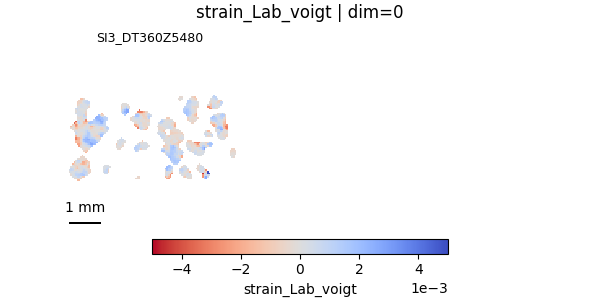

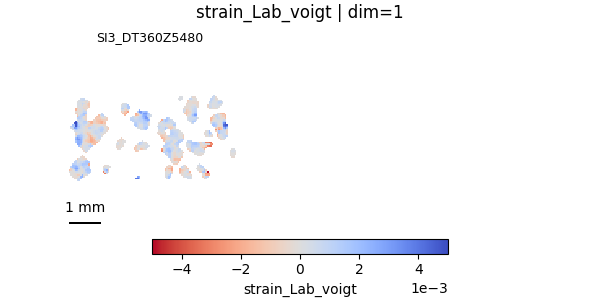

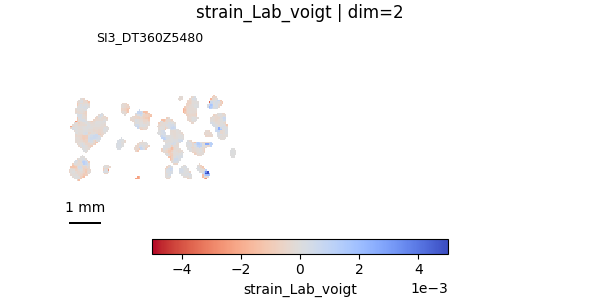

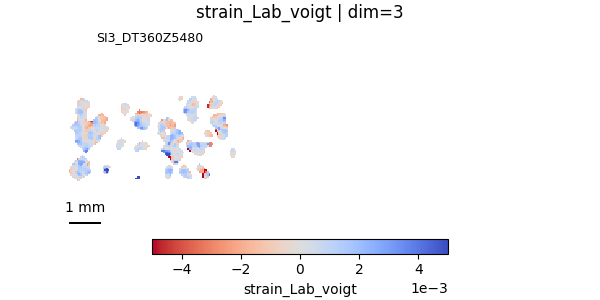

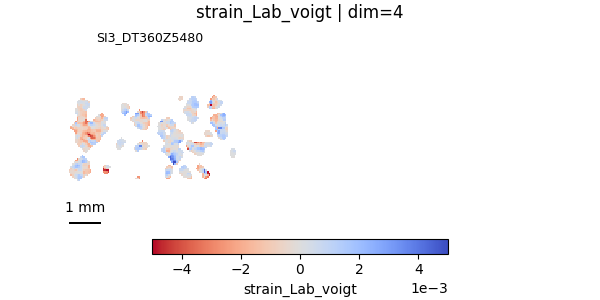

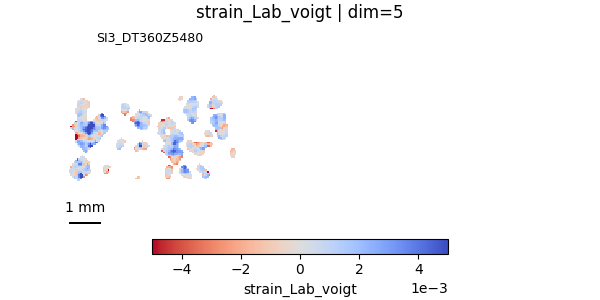

In [70]:
# property stored in ndarray (strain / stress components, unitcell): you need to precise which component 
# to plot with dim. dim = i -> data_array[:,i]


pl.close('all')
save=False
dname = 'strain_Lab_voigt'

# strain/stress voigt components
norm = pl.matplotlib.colors.CenteredNorm(vcenter=0, halfrange=5e-3) 
kw = {'cmap':custom_cmap('coolwarm_r'), 'norm':norm}

for dim in range(6):
    fig = plot_maps_combined(xmap_dict['xmap'],
                             xmap_dict['dsname'],
                             dname, dim, smooth=True, mfs=2, n_columns=2, save=save, outdir = outdir, **kw)
    

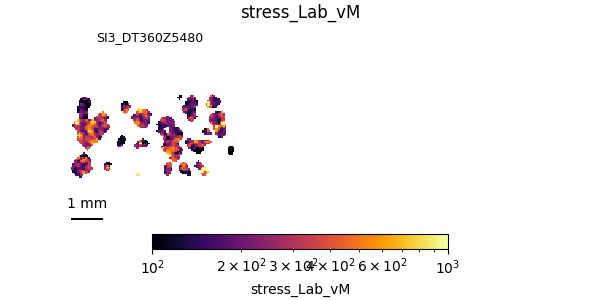

In [71]:
# strain /stress invariants: von Mises strian /stress
save=False
pl.close('all')
dname = 'stress_Lab_vM'

kw = {'cmap':custom_cmap('inferno'), 'norm':pl.matplotlib.colors.LogNorm(vmin=100, vmax=1000)}  # vM  'norm':pl.matplotlib.colors.LogNorm(vmin=1e1, vmax=3e3

fig = plot_maps_combined(xmap_dict['xmap'], xmap_dict['dsname'], dname, dim=0, smooth=True, mfs=2, n_columns=2,
                         save=save, outdir = outdir, **kw)




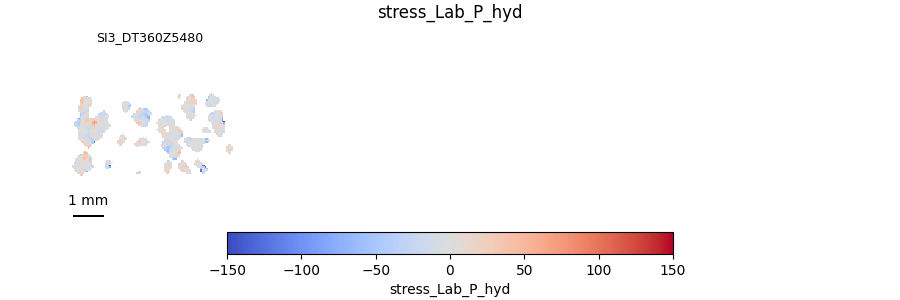

In [72]:
# Pressure
dname = 'stress_Lab_P_hyd'

norm = pl.matplotlib.colors.CenteredNorm(vcenter=0, halfrange=150)   # P_hyd
kw = {'cmap':'coolwarm', 'norm':norm}

fig = plot_maps_combined(xmap_dict['xmap'], xmap_dict['dsname'], dname, dim=0, smooth=True, mfs=2, n_columns=3,
                         save=save, outdir = outdir, **kw)




#### Plots for one slice

If there is only one slice in the stack, the functions above are not very useful. You can use directly functions from xmap to make plots

In [92]:
xmap = xmap_dict['xmap'][0]

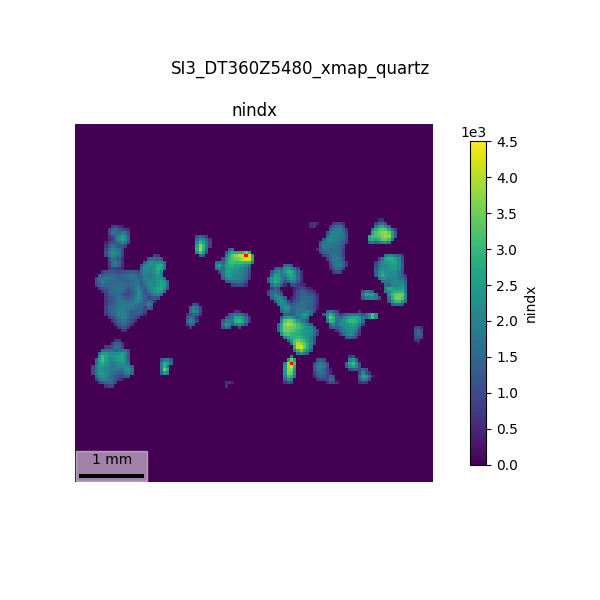

In [78]:
dname = 'nindx'
kw = {'cmap':custom_cmap('viridis', color_under='w', color_over='r'), 'vmin':0, 'vmax':4.5e3}

xmap.plot(dname, smooth=False, save=False, **kw)

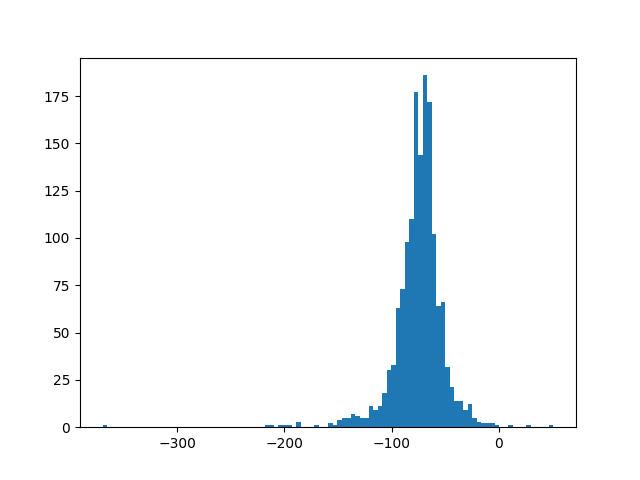

In [105]:
pl.figure()
pl.hist(xmap.stress_Lab_P_hyd[xmap.stress_Lab_P_hyd != np.inf],100);

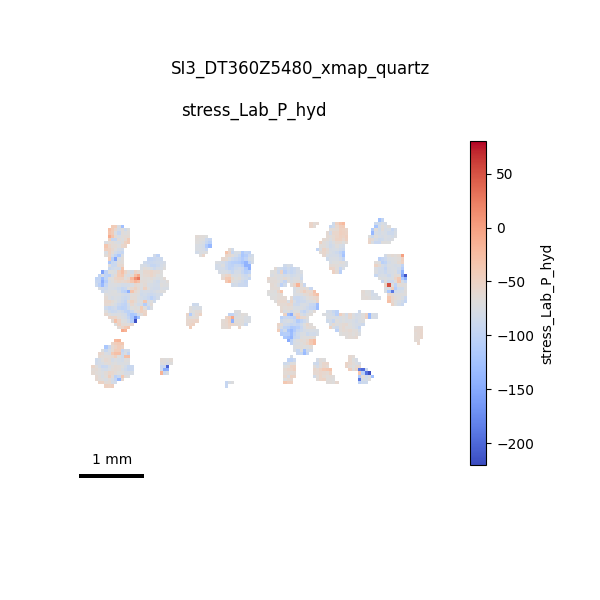

In [107]:
# using centered norm for pressure

norm = pl.matplotlib.colors.CenteredNorm(vcenter=-70, halfrange=150)   # P_hyd
kw = {'cmap':'coolwarm', 'norm':norm}

xmap.plot('stress_Lab_P_hyd', smooth=False, save=False, **kw)

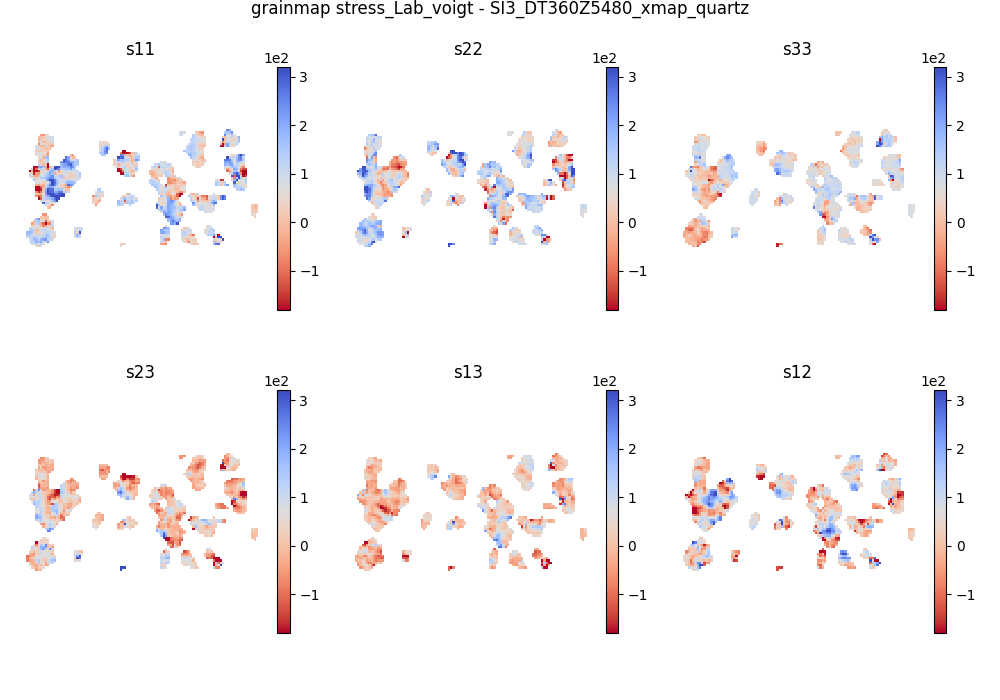

In [111]:
# all strain / stress components in one plot
norm = pl.matplotlib.colors.CenteredNorm(vcenter=0, halfrange=250)   # P_hyd
kw = {'cmap':'coolwarm_r', 'norm':norm}

xmap.plot_voigt_tensor('stress_Lab_voigt', autoscale=False, smooth=False, save=False, **kw)

#### Principal components orientation
Principal component orientation plotted as an ODF on a polefigure

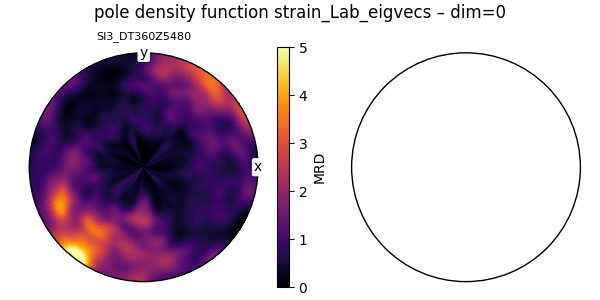

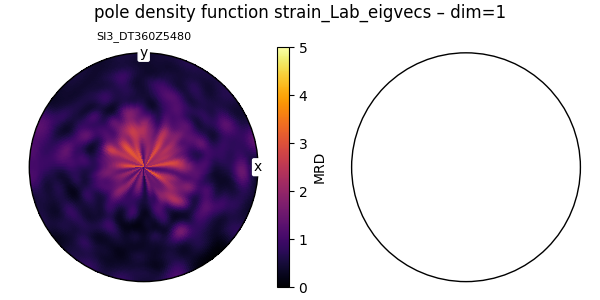

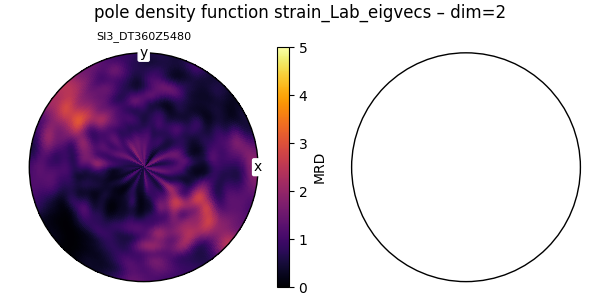

In [113]:
kw_pf = {'cmap':'inferno', 'resolution':1, 'sigma':5, 'vmin':0, 'vmax':3}

save=False

dname = 'strain_Lab_eigvecs'
vmax = [5,5,5]

for i in range(3):
    kw_pf['vmax'] = vmax[i]
    plot_polefigs_combined(xmap_dict['xmap'],xmap_dict['dsname'],dname, dim=i, polar_res=0.1, az_res=0.1,
                           n_columns=2, save=save, outdir = outdir, **kw_pf)
    

#### Principal components orientation - bis
Angle between principal component vector (sigma1,2,3) and a selected direction in Lab coordinates (default = z axis) plotted as a colormap

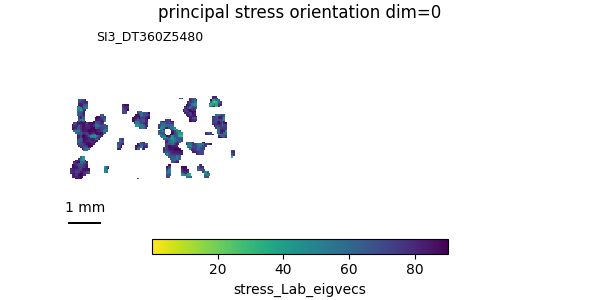

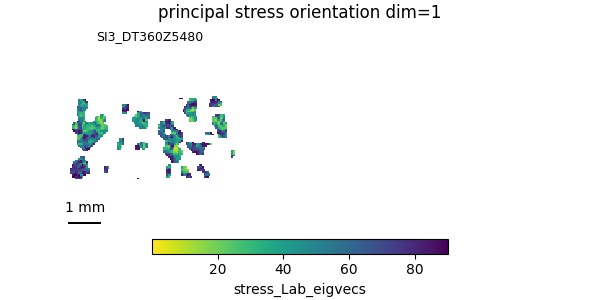

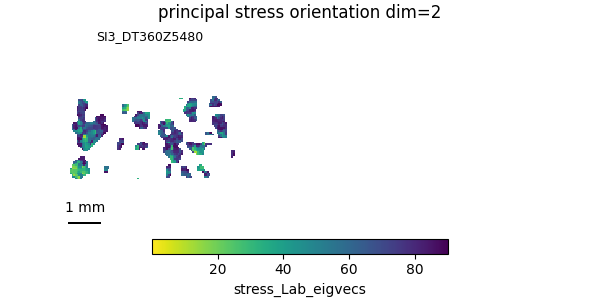

In [116]:
kw_ang = {'cmap':custom_cmap('viridis_r', color_over='w'), 'vmin':0.1, 'vmax':90}

save=False
dname = 'stress_Lab_eigvecs'

for i in range(3):
    plot_ang_maps_combined(xmap_dict['xmap'],xmap_dict['dsname'],dname, v0 = ovec.Vector3d((0,0,1)),
                           dim = i, smooth = True, mfs=2, n_columns=2, save=save, outdir=outdir, **kw_ang)

### Sort outputs and update names

- Sort plotted figures by category : strain/stress and grain/pixel
- update figure names to be more meaningful

In [117]:
# sort outputs
import glob

paths = glob.glob(outdir+'/*')
groups = ['strain_Lab_px', 'strain_Lab_g', 'stress_Lab_px', 'stress_Lab_g']
key1 = ['_'.join(g.split('_')[0:1]) for g in groups]
key2 = ['','_g','','_g']

# sort by group
for g,k1,k2 in zip(groups,key1,key2):
    !mkdir -p {os.path.join(outdir, g)}
    
    if k2 == '_g':
        sel = [p for p in paths if k1 in p and k2 in p and not os.path.isdir(p)]
    else:
        sel = [p for p in paths if k1 in p and '_g' not in p and not os.path.isdir(p)]
    
    # move to group directory
    for s in tqdm(sel):
        !mv {s} {os.path.join(outdir,g)}

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [504]:
# rename files with accurate strain / stress component n0 (voigt)
import re

def extract_index(string):
    match = re.search(r'(\d+)', string)
    if match:
        index = int(match.group(1))
        return index
    else:
        return None
    
def remove_integers(input_string):
    # Use re.sub to replace all digits with an empty string
    result_string = re.sub(r'\d+', '', input_string)
    return result_string

    
def ind_to_xyz(index):
    # converts index of voigt tensor components: e1,e2,e3,e4,e5,e6 -> exx,eyy,ezz,exz,eyz,exy
    mapping = {1: "xx", 2: "yy", 3: "zz", 4: "xz", 5: "yz", 6: "xy"}
    if index in mapping:
        return mapping[index]
    else:
        return None
    

def newfilename(namein):
    
    ind = extract_index(namein)
    endstr = remove_integers(namein.split('_')[-1])
    if endstr.startswith('_'):
        endstr = endstr[1:]
    
    
    stem=''
    
    if all(['strain' in namein,'voigt' in namein, ind is not None]):
        ind = ind_to_xyz(ind+1)
        stem = f'ε{ind}_voigt'
                   
    if all(['strain' in namein,'eig' in namein, ind is not None]):                 
        ind = ind+1
        stem = f'ε{ind}'
    
    if all(['stress' in namein,'voigt' in namein, ind is not None]):
        ind = ind_to_xyz(ind+1)
        stem = f'σ{ind}_voigt'
                   
    if all(['stress' in namein,'eig' in namein, ind is not None]):                 
        ind = 3 - ind
        stem = f'σ{ind}'

    if all(['strain' in namein, 'vM' in namein]):
        stem = 'von_Mises_strain'

    if all(['stress' in namein, 'vM' in namein]):
        stem = 'von_Mises_stress'

    if stem == '':
        #print('filename not recognized')
        return namein
    
    if endstr.startswith('.'):
        nameout = f'{stem}{endstr}'
    else:
        nameout = f'{stem}_{endstr}'
    
    if '_d_' in namein:
        stem2 = 'delta'
        nameout = f'{stem2}_{nameout}'
        
    return nameout

In [505]:
for g in groups:
    for path in tqdm(glob.glob(os.path.join(outdir,g,'*'))):
        if os.path.isdir(path):
                continue
        namein = path.split('/')[-1]
        nameout = newfilename(namein)
        
        if nameout.startswith('_'):
            nameout= nameout[1:]
        
        newpath = path.replace(namein,nameout)
        !mv {path} {newpath}

100%|██████████| 16/16 [00:04<00:00,  3.51it/s]
0it [00:00, ?it/s]
 50%|█████     | 12/24 [00:03<00:03,  3.50it/s]

mv: '/data/visitor/es1190/id11/20240515/PROCESSED_DATA/ANALYSIS/WG_H0524_01/combined_orthoclase/stress_Lab_px/stress_Lab_P_hyd.png' and '/data/visitor/es1190/id11/20240515/PROCESSED_DATA/ANALYSIS/WG_H0524_01/combined_orthoclase/stress_Lab_px/stress_Lab_P_hyd.png' are the same file


 92%|█████████▏| 22/24 [00:06<00:00,  3.50it/s]

mv: '/data/visitor/es1190/id11/20240515/PROCESSED_DATA/ANALYSIS/WG_H0524_01/combined_orthoclase/stress_Lab_px/diff_stress.png' and '/data/visitor/es1190/id11/20240515/PROCESSED_DATA/ANALYSIS/WG_H0524_01/combined_orthoclase/stress_Lab_px/diff_stress.png' are the same file


100%|██████████| 24/24 [00:06<00:00,  3.51it/s]
0it [00:00, ?it/s]
